# HemoCell Visualizations for the article

In [26]:
import numpy as np
import pandas as pd

import tqdm

import matplotlib.pyplot as plt

from lxml import etree

from SALib.sample import saltelli
from SALib.analyze import sobol

from sklearn.neighbors.kde import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel

import statsmodels.api as sm

from local_config import *

print(plt.style.available)
#plt.style.use("ggplot")

titlefontsize = 24
axisfontsize = 24
labelfontsize = 20

plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

['seaborn-muted', 'seaborn-deep', 'seaborn-ticks', 'seaborn-dark', 'dark_background', 'seaborn-pastel', 'seaborn-darkgrid', 'seaborn-colorblind', 'tableau-colorblind10', 'fivethirtyeight', 'seaborn-talk', 'grayscale', '_classic_test', 'seaborn', 'seaborn-white', 'fast', 'bmh', 'ggplot', 'classic', 'seaborn-poster', 'seaborn-dark-palette', 'seaborn-paper', 'Solarize_Light2', 'seaborn-notebook', 'seaborn-whitegrid', 'seaborn-bright']


In [27]:
mode = "visc"
cellHealth = "treated"
lmax = 1

if cellHealth == "healthy":
    imin = 2
    imax = 8
    
    HC_violin_color = "green"
    HC_cmap = "Greens"
    
    GP_violin_color = "red"
    GP_cmap = "Reds"
elif cellHealth == "treated":
    imin = 4
    imax = 10
    
    HC_violin_color = "orange"
    HC_cmap = "Oranges"
    
    GP_violin_color = "blue"
    GP_cmap = "Blues"

# Load results from posterior sampling

# HemoCell model
HC_df = pd.read_csv("%s/TMCMC_hemocell_%s_samples_%s_%i_%i_lmax_%i.csv" % 
                    (outputpath,cellHealth,mode,imin,imax,lmax),sep=";")

HC_qoi = np.load("%s/TMCMC_hemocell_%s_qoi_%s_%i_%i_lmax_%i.npy" % 
                 (outputpath,cellHealth,mode,imin,imax,lmax))

HC_c_err = np.load("%s/TMCMC_hemocell_%s_c_err_%s_%i_%i_lmax_%i.npy" % 
                   (outputpath,cellHealth,mode,imin,imax,lmax))

# Gaussian Process model
GP_df = pd.read_csv("%s/TMCMC_GP_%s_samples_%s_%i_%i_lmax_%i.csv" % 
                    (outputpath,cellHealth,mode,imin,imax,lmax),sep=";")

GP_qoi = np.load("%s/TMCMC_GP_%s_qoi_%s_%i_%i_lmax_%i.npy" % 
                 (outputpath,cellHealth,mode,imin,imax,lmax))

GP_c_err = np.load("%s/TMCMC_GP_%s_c_err_%s_%i_%i_lmax_%i.npy" % 
                   (outputpath,cellHealth,mode,imin,imax,lmax))

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]

if cellHealth == "treated":
    stress,el,el_err = data.values[imin:imax,[1,3,4]].T    
elif cellHealth == "healthy":
    stress,el = data.values[imin:imax,[1,2]].T 
    el_err = np.zeros(el.shape)

# Parameter names
params = ["kLink","kBend"]

if mode == "visc":
    params.append("viscosityRatio")

#params = params + ["err"]
    
    
names = {"kLink":r"$\kappa_l$","kBend":r"$\kappa_b$",
         "viscosityRatio":r"$\Lambda$","err":r"$\sigma^m$",
         "shearrate":r"$\dot{\gamma}$ [$s^{-1}$]"}

# Data visualizations

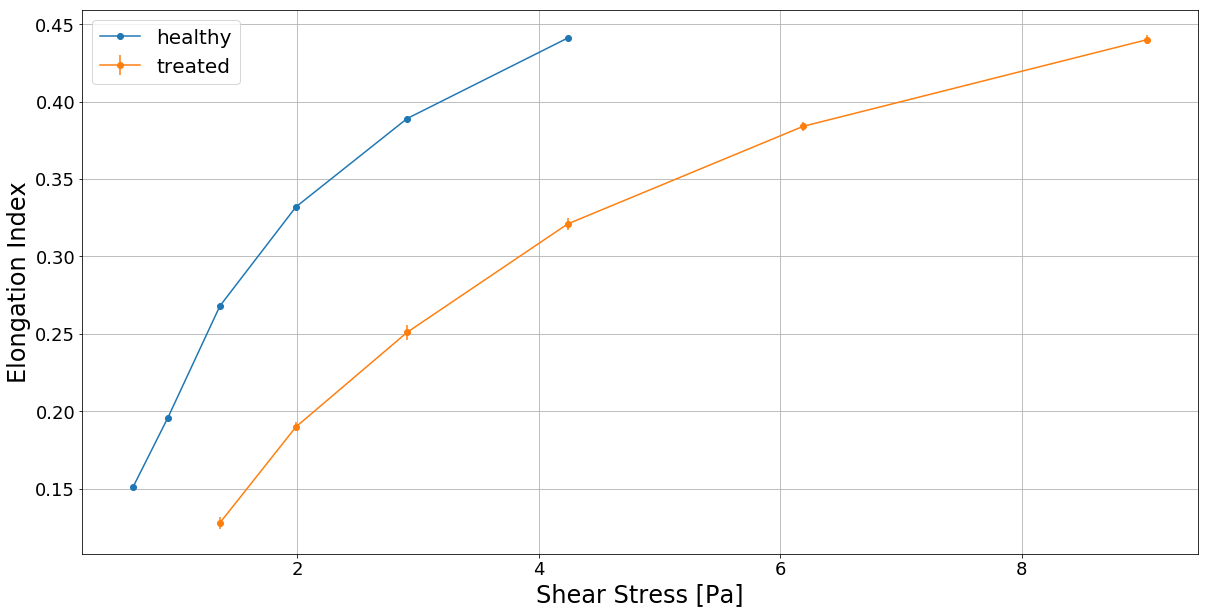

In [28]:
full_stress,el_healthy,el_treated,el_treated_err = data.values[0:10,[1,2,3,4]].T

dx = full_stress[1:] - full_stress[:-1]
dy_healthy = el_healthy[1:] - el_healthy[:-1]
dy_treated = el_treated[1:] - el_treated[:-1]

x = (full_stress[:-1] + full_stress[1:]) / 2

plt.figure(figsize=(20,10))

plt.xlabel("Shear Stress [Pa]",fontsize=axisfontsize)
plt.ylabel("Elongation Index",fontsize=axisfontsize)
plt.grid(True)
plt.plot(full_stress[2:8],el_healthy[2:8],"o-",label="healthy")
plt.errorbar(full_stress[4:10],el_treated[4:10],yerr=el_treated_err[4:10],fmt="o-",label="treated")
plt.legend(fontsize=labelfontsize)

plt.show()

# UQ visualizations

## 1D Marginalized figures (HemoCell & GP together)

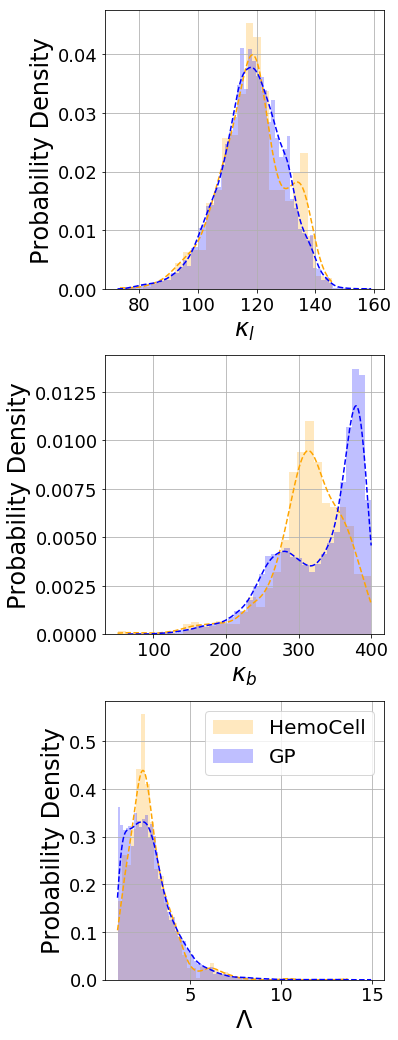

In [29]:
plt.figure(figsize=(5,18))
for n in range(len(params)):
    ax = plt.subplot(3,1,n+1)
    plt.grid(True)
    
    #if n == 0:
    plt.ylabel("Probability Density",fontsize=axisfontsize)
    
    plt.xlabel(names[params[n]],fontsize=axisfontsize)
    
    HC_vals = HC_df[params[n]].values
    HC_kde = sm.nonparametric.KDEMultivariate(data=HC_vals,var_type="c",bw="normal_reference")
    HC_x_vals = np.linspace(np.min(HC_vals),np.max(HC_vals),1000)
    HC_y_vals = HC_kde.pdf(HC_x_vals)
    
    GP_vals = GP_df[params[n]].values
    GP_kde = sm.nonparametric.KDEMultivariate(data=GP_vals,var_type="c",bw="normal_reference")
    GP_x_vals = np.linspace(np.min(GP_vals),np.max(GP_vals),1000)
    GP_y_vals = GP_kde.pdf(GP_x_vals)
    
    plt.hist(HC_df[params[n]].values,color=HC_violin_color,bins="auto",
             density=True,alpha=0.25,label="HemoCell")
    
    plt.plot(HC_x_vals,HC_y_vals,'--',color=HC_violin_color)
    
    plt.hist(GP_df[params[n]].values,color=GP_violin_color,bins="auto",
             density=True,alpha=0.25,label="GP")
    
    plt.plot(GP_x_vals,GP_y_vals,'--',color=GP_violin_color)
    
    x0,x1 = plt.gca().get_xlim()
    y0,y1 = plt.gca().get_ylim()

    plt.gca().set_aspect((x1-x0)/(y1-y0))
    
ax.legend(fontsize=labelfontsize)
plt.show()

## 2D Samples scatterplot (Left: HemoCell, Right: GP model)

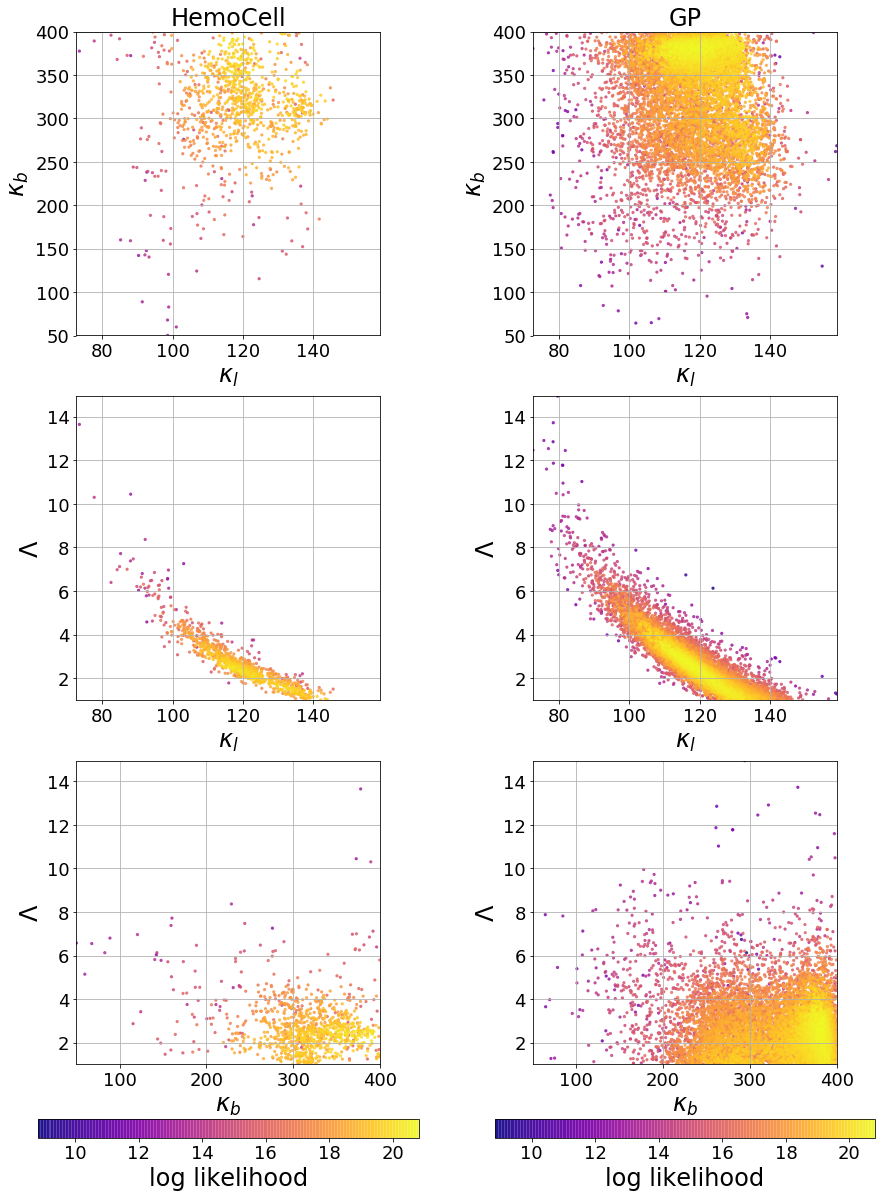

In [30]:
pad = 0.025

ny,nx = 3,2
fig, axs = plt.subplots(ny,nx,figsize=(15,40))
orientation = "horizontal"

flat = axs.flatten()

flat[0].set_title("HemoCell",fontsize=titlefontsize)
flat[1].set_title("GP",fontsize=titlefontsize)

count = 2
s = 5

plots = []
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            HC_vals = HC_df[[params[n],params[m]]].values
            GP_vals = GP_df[[params[n],params[m]]].values
            
            xmin = min(np.min(HC_vals[:,0]),np.min(GP_vals[:,0]))
            xmax = max(np.max(HC_vals[:,0]),np.max(GP_vals[:,0]))
            
            ymin = min(np.min(HC_vals[:,1]),np.min(GP_vals[:,1]))
            ymax = max(np.max(HC_vals[:,1]),np.max(GP_vals[:,1]))
            
            HC_logs = np.log(HC_df["likelihood"].values)
            GP_logs = np.log(GP_df["likelihood"].values)

            vmin = min(np.min(HC_logs),np.min(GP_logs))
            vmax = max(np.max(HC_logs),np.max(GP_logs))
            
            flat[count-2].grid(True)
            flat[count-2].set_xlabel(names[params[n]],fontsize=axisfontsize)
            flat[count-2].set_ylabel(names[params[m]],fontsize=axisfontsize)
                
            flat[count-2].set_xlim(xmin,xmax)
            flat[count-2].set_ylim(ymin,ymax)
                
            order = np.argsort(HC_df["likelihood"])
            plots.append(flat[count-2].scatter(HC_df[params[n]].values[order],
                                               HC_df[params[m]].values[order],
                                               s=s,c=np.log(HC_df["likelihood"].values[order]),
                                               vmin=vmin,vmax=vmax,cmap="plasma",alpha=0.75))
            
            x0,x1 = flat[count-2].get_xlim()
            y0,y1 = flat[count-2].get_ylim()
            
            flat[count-2].set_aspect((x1-x0)/(y1-y0))
            
                
            flat[count-1].grid(True)
            flat[count-1].set_xlabel(names[params[n]],fontsize=axisfontsize)
            flat[count-1].set_ylabel(names[params[m]],fontsize=axisfontsize)
            
            flat[count-1].set_xlim(xmin,xmax)
            flat[count-1].set_ylim(ymin,ymax)
                
            order = np.argsort(GP_df["likelihood"])
            plots.append(flat[count-1].scatter(GP_df[params[n]].values[order],
                                               GP_df[params[m]].values[order],
                                               s=s,c=np.log(GP_df["likelihood"].values[order]),
                                               vmin=vmin,vmax=vmax,cmap="plasma",alpha=0.75))
            
            x0,x1 = flat[count-1].get_xlim()
            y0,y1 = flat[count-1].get_ylim()
            
            flat[count-1].set_aspect((x1-x0)/(y1-y0))
            
            count += 2
            
fig.colorbar(plots[-2],ax=axs[:,0],fraction=0.5,
             pad=pad,orientation=orientation).set_label(label="log likelihood",size=axisfontsize)

fig.colorbar(plots[-1],ax=axs[:,1],fraction=0.5,
             pad=pad,orientation=orientation).set_label(label="log likelihood",size=axisfontsize)

plt.show()

## 2D Kernel Density Estimations (Left: HemoCell, Right: GP)

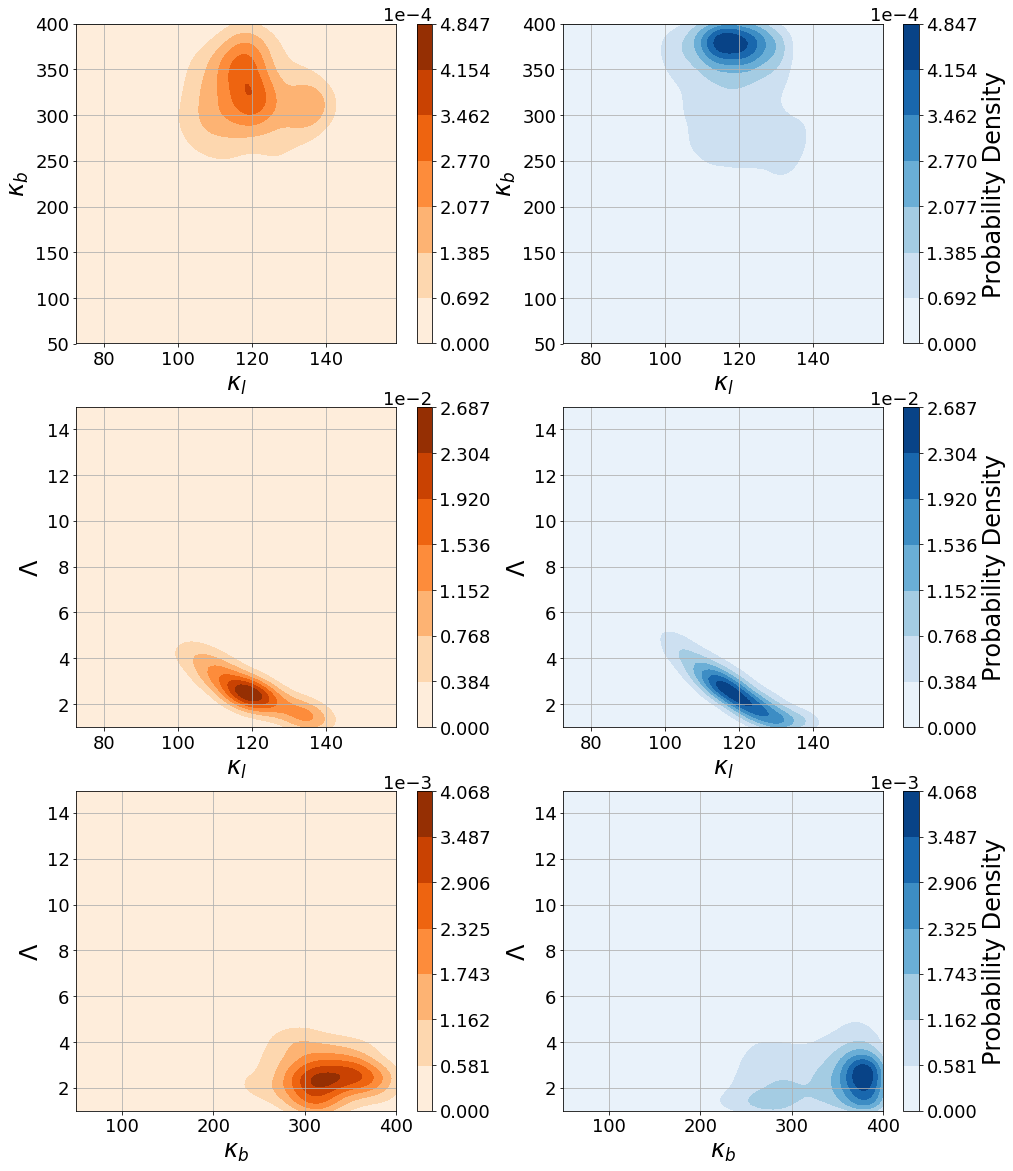

In [6]:
plt.figure(figsize=(16,20))

count = 1

plots = []
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            HC_vals = HC_df[[params[n],params[m]]].values
            GP_vals = GP_df[[params[n],params[m]]].values
            
            xmin = min(np.min(HC_vals[:,0]),np.min(GP_vals[:,0]))
            xmax = max(np.max(HC_vals[:,0]),np.max(GP_vals[:,0]))
            
            ymin = min(np.min(HC_vals[:,1]),np.min(GP_vals[:,1]))
            ymax = max(np.max(HC_vals[:,1]),np.max(GP_vals[:,1]))
            
            HC_kde = sm.nonparametric.KDEMultivariate(data=HC_vals,var_type="cc",bw="normal_reference")
            GP_kde = sm.nonparametric.KDEMultivariate(data=GP_vals,var_type="cc",bw="normal_reference")
            
            x = np.linspace(xmin,xmax,100)
            y = np.linspace(ymin,ymax,100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            
            HC_grid_vals = HC_kde.pdf(grid_flat).reshape(xx.shape)
            GP_grid_vals = GP_kde.pdf(grid_flat).reshape(xx.shape)
            
            vmin = min(np.min(HC_grid_vals),np.min(GP_grid_vals))
            vmax = max(np.max(HC_grid_vals),np.max(GP_grid_vals))
            
            levels = np.linspace(vmin,vmax,8)
            
            ax = plt.subplot(3,2,count)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=axisfontsize)
            plt.ylabel(names[params[m]],fontsize=axisfontsize)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            
            cont = plt.contourf(xx,yy,HC_grid_vals,vmin=vmin,vmax=vmax,levels=levels,cmap=HC_cmap)
            cbar = plt.colorbar(cont)
                        
            cbar.set_clim(vmin,vmax)
                
            cbar.formatter.set_powerlimits((-4,-3))
            cbar.update_ticks()
            
            x0,x1 = plt.gca().get_xlim()
            y0,y1 = plt.gca().get_ylim()
            
            plt.gca().set_aspect((x1-x0)/(y1-y0))
            
            count += 1
            
            plt.subplot(3,2,count)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=axisfontsize)
            plt.ylabel(names[params[m]],fontsize=axisfontsize)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
            
            cont = plt.contourf(xx,yy,GP_grid_vals,vmin=vmin,vmax=vmax,levels=levels,cmap=GP_cmap)
            cbar = plt.colorbar(cont)
            
            cbar.set_clim(vmin,vmax)
            
            cbar.formatter.set_powerlimits((-4,-3))
            cbar.update_ticks()
            
            cbar.set_label("Probability Density",size=axisfontsize)
            
            x0,x1 = plt.gca().get_xlim()
            y0,y1 = plt.gca().get_ylim()
            
            plt.gca().set_aspect((x1-x0)/(y1-y0))
                
            count += 1


plt.show()